# NAIST DSC Summer Seminar


## はじめての分子グラフコンボリューション : How to use Molecular Graph Convolutional Neural Networks

今回のモデルではDeepChemパッケージに含まれているMGCNNの関数を使います。

https://deepchem.io/

DeepChem自体はGCNNの他にもいろいろな分子関係の関数が入ったパッケージです。

First of all we need install DeepChem packages.

Unfortunately, there is no pip packages so that we need install from github.

Moreover, it depends on several packages which can be installed via anaconda. 

In [1]:
# confirm your python environment
import sys
print(sys.version)


3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [0]:
%%bash
# shell command mode
# Installing some packages which DeepChem depends on, using MiniConda.
wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O anaconda.sh;
chmod +x anaconda.sh
bash ./anaconda.sh -b -f -p /usr/local
conda update -n base -c defaults conda

In [0]:
! conda install -y --prefix /usr/local -c conda-forge rdkit

In [0]:
! conda install -y --prefix /usr/local -c conda-forge joblib

In [0]:
! conda install -y --prefix /usr/local -c conda-forge simdna

In [0]:
! git clone https://github.com/deepchem/deepchem.git      # Clone deepchem source code from GitHub
! cd deepchem && python setup.py install

In [11]:
! ls /usr/local/lib/python3.6/site-packages/deepchem
! ls /usr/local/lib/python3.7/site-packages/deepchem
! cat /usr/local/lib/python3.7/site-packages/deepchem/__init__.py

ls: cannot access '/usr/local/lib/python3.6/site-packages/deepchem': No such file or directory
data  feat   __init__.py   metrics  molnet	 rl	 tests	utils
dock  hyper  metalearning  models   __pycache__  splits  trans
"""
Imports all submodules
"""
from __future__ import division
from __future__ import unicode_literals

__version__ = '2.1.1'

import deepchem.data
import deepchem.feat
import deepchem.hyper
import deepchem.metalearning
import deepchem.metrics
import deepchem.models
import deepchem.splits
import deepchem.trans
import deepchem.utils
import deepchem.dock
import deepchem.molnet
import deepchem.rl


In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [13]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.7/site-packages/']

Well done! 

Let's start convolution now.

In [0]:
import numpy as np
import pandas as pd
import rdkit
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
import deepchem as dc
from deepchem.models.tensorgraph.tensor_graph import TensorGraph
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.tensorgraph.layers import Feature

from deepchem.models.tensorgraph.layers import GraphConv
from deepchem.models.tensorgraph.layers import GraphGather
from deepchem.models.tensorgraph.layers import Dense

from deepchem.models.tensorgraph.layers import SoftMax, SoftMaxCrossEntropy

from deepchem.models.tensorgraph.layers import L2Loss

from deepchem.models.tensorgraph.layers import ReduceMean

from deepchem.metrics import to_one_hot

### Data set
For evaluation, we apply our method for the dataset published by

The Toxicology in the 21st Century (Tox21) Consortium 

https://tox21.gov/

In [16]:
# Load Tox21 dataset
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 21.144 s
TIMING: dataset construction took 24.199 s
Loading dataset from disk.
TIMING: dataset construction took 3.977 s
Loading dataset from disk.
TIMING: dataset construction took 3.506 s
Loading dataset from disk.
TIMING: dataset construction took 1.487 s
Loading dataset from disk.
TIMING: dataset construction took 1.763 s
Loading dataset from disk.


There are 12 different tasks (toxins) to be evaluated.

You may choose any interesting one.

Here I chose 'SR-MMP'

In [46]:
tox21_tasks

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

## 1. Use the ready made GraphConv model

In [0]:
model1 = GraphConvModel(len(tox21_tasks), batch_size=20, mode='classification')

In [47]:
# Set nb_epoch=10 for better results.
model1.fit(train_dataset, nb_epoch=10)

Ending global_step 1890: Average loss 0.425058
TIMING: model fitting took 45.354 s


0.42505824818970667

In [54]:
test_pred = model1.predict(test_dataset)

print(np.sum(np.logical_and(test_dataset.y[:,10]==0, test_pred[:,10,0] < 0.5)) / test_pred.shape[0])
print(np.sum(np.logical_and(test_dataset.y[:,10]==1, test_pred[:,10,0] > 0.5)) / test_pred.shape[0])


0.23469387755102042
0.021683673469387755


(array([ 81.,  47.,  55.,  29.,  52.,  45.,  58.,  64.,  94., 259.]),
 array([0.00175069, 0.10150457, 0.20125845, 0.30101234, 0.40076622,
        0.5005201 , 0.60027397, 0.7000279 , 0.79978174, 0.89953566,
        0.9992895 ], dtype=float32),
 <a list of 10 Patch objects>)

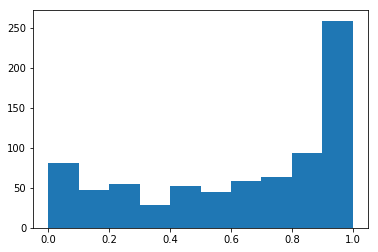

In [55]:
plt.hist(test_pred[:,10,0])

## 2. Construct your GraphConv model

In [0]:
tg = TensorGraph(use_queue=False)

### Prepare input features

First you need to setup a set of input layers.

That includes atoms and their connections, i.e. adjacency matrixes.


In [110]:
atom_features = Feature(shape=(None, 75), name='atom_features')
degree_slice = Feature(shape=(None, 2), dtype=tf.int32, name='degree_slice')
membership = Feature(shape=(None,), dtype=tf.int32, name='membership')
n_deg_adj = len(mol1.get_deg_adjacency_lists())
n_deg_adj

11

In [0]:
deg_adj_list = []
for i in range(1, n_deg_adj):
    tmp = Feature(shape=(None, i), dtype=tf.int32, name='deg_adj_{}'.format(i))
    deg_adj_list.append(tmp)

And a vector of objective variable (target variable, or, labels to classify)

In [0]:
# target1 = Feature(shape=(None, 1), name='target1')
# label1 = Feature(shape=(None, 3), name='label1')
label1 = Feature(shape=(None, 1), name='label1')

### GCNN

Now you can setup your convolution networks.

In [0]:
n_batch = 20
i_task = 10
n_f1 = 32
n_f2 = 64

l1 = GraphConv(n_f1, activation_fn=tf.nn.relu, in_layers=[atom_features, degree_slice, membership] + deg_adj_list, name='l1_conv')
l2 = GraphConv(n_f2, activation_fn=tf.nn.relu, in_layers=[l1, degree_slice, membership] + deg_adj_list, name='l2_conv')
l3 = GraphGather(batch_size=n_batch, activation_fn=tf.nn.tanh, in_layers=[l2, degree_slice, membership] + deg_adj_list, name='l3_gather')
l4 = Dense(out_channels=1, activation_fn=None, in_layers=[l3], name='l4_classification')
l5 = SoftMax(in_layers=[l4], name='l5_softmax')
tg.add_output(l5)

l6 = ReduceMean(L2Loss([l4, label1]), name='l6_loss')
tg.set_loss(l6)

Remember to compile your network befor evaluation.

In [114]:
if(not tg.built):
    tg.build()


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [122]:
label1.shape

(None, 1)

In [116]:
train_dataset.y[0:n_batch, i_task]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In this case, we apply "feed generator" method to run iteration batches.

One feed dict contains all information of molecules in a batch.

Here I construct a feed_dict1 just for evaluation of test codes.

In [0]:
mol1 = ConvMol.agglomerate_mols(train_dataset.X[0:n_batch])
feed_dict1 = {}
feed_dict1[atom_features] = mol1.get_atom_features()
feed_dict1[degree_slice] = mol1.deg_slice
feed_dict1[membership] = mol1.membership

# feed_dict1[label1] = to_one_hot(train_dataset.y[0:n_batch, i_task]+1, n_classes=3)
feed_dict1[label1] = train_dataset.y[0:n_batch, i_task:(i_task+1)]+1

n_deg_adj = len(mol1.get_deg_adjacency_lists())

for i in range(1, n_deg_adj):
    feed_dict1[deg_adj_list[i-1]] = mol1.get_deg_adjacency_lists()[i]

Actually, a feed dict shall automatically generated by the data_generator below.
Note that `yield` called inside the epoch loop to return each batch.

In [0]:
n_report = 10

def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
    for epoch in range(epochs):
        if not predict:
            if not n_report == 0:
                if epoch % n_report == 0:
                    print('Starting epoch %i' % epoch)
        for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(n_batch, pad_batches=True, deterministic=True)):
            d = {}
            #d[label1] = to_one_hot(y_b[:,0]+1,n_classes=3)
            d[label1] = y_b[:,i_task:(i_task+1)]+1
            multiConvMol = ConvMol.agglomerate_mols(X_b)
            d[atom_features] = multiConvMol.get_atom_features()
            d[degree_slice] = multiConvMol.deg_slice
            d[membership] = multiConvMol.membership
            for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
                d[deg_adj_list[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
            yield d

In [137]:
feed_dict1[label1].shape

(20, 1)

In [138]:
for hoge in data_generator(train_dataset, epochs=1):
  hoge
hoge[label1]

Starting epoch 0


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [139]:
l6.out_tensor.eval(session=tg.session, feed_dict=feed_dict1)

0.017333372

Now run `fit`.

First you'd better try a few epochs.
If its OK., try much longer.

In [181]:
tg.fit_generator(data_generator(train_dataset, epochs=30))

Starting epoch 0
Starting epoch 10
Starting epoch 20


0.03316733075651934

You can generate predcted value for the given test dataset.

In [0]:
hoge = tg.predict_on_generator(data_generator(test_dataset))
print(hoge)


In [179]:
print(np.sum(hoge[0:784] == 1))
print(np.sum(hoge[0:784] == 2))
             
print(np.sum(np.logical_and(hoge[0:len(test_dataset.y[:,i_task:(i_task+1)])] == 1, test_dataset.y[:,i_task:(i_task+1)]==0)))
print(np.sum(np.logical_and(hoge[0:len(test_dataset.y[:,i_task:(i_task+1)])] == 1, test_dataset.y[:,i_task:(i_task+1)]==1)))
print(np.sum(np.logical_and(hoge[0:len(test_dataset.y[:,i_task:(i_task+1)])] == 2, test_dataset.y[:,i_task:(i_task+1)]==0)))
print(np.sum(np.logical_and(hoge[0:len(test_dataset.y[:,i_task:(i_task+1)])] == 2, test_dataset.y[:,i_task:(i_task+1)]==1)))

784
0
687
97
0
0


### Appendix

In [0]:
from google.colab import files
uploaded = files.upload()

In [35]:
!curl https://raw.githubusercontent.com/pdcoded/fox/master/tox21_sdf/tox21_10k_data_all.sdf -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.5M  100 23.5M    0     0  47.8M      0 --:--:-- --:--:-- --:--:-- 47.7M


In [36]:
#SDF file to mol and Dataframe
def sdf_to_df(filepass):
    mols = [mol for mol in Chem.SDMolSupplier(filepass, sort=False) if mol is not None]
    for id, mol in enumerate(mols):
        if id == 0:
            dicts = mol.GetPropsAsDict()
            df = pd.DataFrame(dicts, index=[id,])
        else:
            dicts = mol.GetPropsAsDict()
            dfplus = pd.DataFrame(dicts, index=[id,])
            df = df.append(dfplus)
    return mols, df

train_x, train_df = sdf_to_df('./tox21_10k_data_all.sdf')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [45]:
print(len(train_x))
print(train_x[0])

11758


In [47]:
mol1 = train_x[1]
#print(Chem.MolToMolBlock(mol1))
print(Chem.MolToSmiles(mol1))

O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(Br)c([O-])c(Br)cc12.[Na+].[Na+]


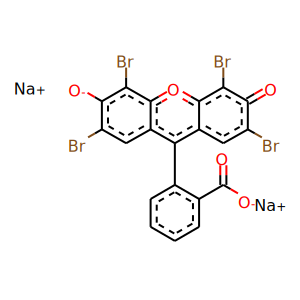

In [48]:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D
# SVG(Chem.MolToSVG(mol1))
drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
drawer.DrawMolecule(mol1)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
SVG(svg)

In [64]:
print(train_df['SR-MMP'][0:10])  ## Small Molecule Disruptors Of The Mitochondrial Membrane Potential
iii_na = np.isnan(train_df['SR-MMP'])
print(np.sum(iii_na))


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: SR-MMP, dtype: float64
4442


In [65]:
iii_na.shape

(11758,)

In [77]:
iii_na = np.logical_not(np.isnan(train_df['SR-MMP']))
print(np.sum(iii_na))
train_xx = np.asarray(train_x)[iii_na]
train_yy = np.asarray(train_df['SR-MMP'])[iii_na]

7316


(array([6174.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1142.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

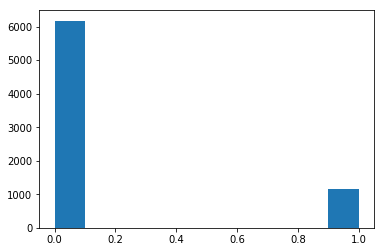

In [76]:
plt.hist(train_yy)

In [78]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Dropout, Activation

Using TensorFlow backend.


In [0]:
from rdkit.Chem import AllChem

tmp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in train_xx]
train_fp = np.stack(tmp,0)


In [81]:
train_fp.shape

(11758, 1024)

In [79]:
model1 = Sequential()
model1.add(Dense(16, input_shape=(1024,), activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='relu'))
model1.summary()

W0724 01:58:15.321415 140056600762240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 01:58:15.372077 140056600762240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 01:58:15.384217 140056600762240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 01:58:15.420714 140056600762240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 01:58:15.432105 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                16400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [87]:
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

AttributeError: ignored